In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import scrublet as scr
import seaborn as sns
import scipy.stats
import anndata
import os
import scipy as scipy
import scipy as sp
import pickle as pkl
import matplotlib.pyplot as plt
import re
from collections import defaultdict
from statsmodels.nonparametric.smoothers_lowess import lowess
from numpy import asarray as ar
from collections import Counter
import networkx as nx
import igraph
import glob

import bbknn

os.getcwd()

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=100, color_map='Blues')
sc.logging.print_version_and_date()
sc.logging.print_header()

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-r97bcglg because the default path (/home/ubuntu/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


Running Scanpy 1.6.0, on 2022-03-07 12:21.
scanpy==1.6.0 anndata==0.7.5 umap==0.4.6 numpy==1.19.5 scipy==1.5.4 pandas==1.1.5 scikit-learn==0.24.2 statsmodels==0.12.2 python-igraph==0.9.8 louvain==0.7.0


In [2]:
def intersection(lst1, lst2): 
    lst3 = [value for value in lst1 if value in lst2] 
    return lst3 

def subtraction(lst1, lst2): 
    lst3 = [value for value in lst1 if not value in lst2] 
    return lst3

### Importing data

In [3]:
adata = sc.read('/mnt/Science_revision/write/TICA_merged_singlets_immune.h5ad')

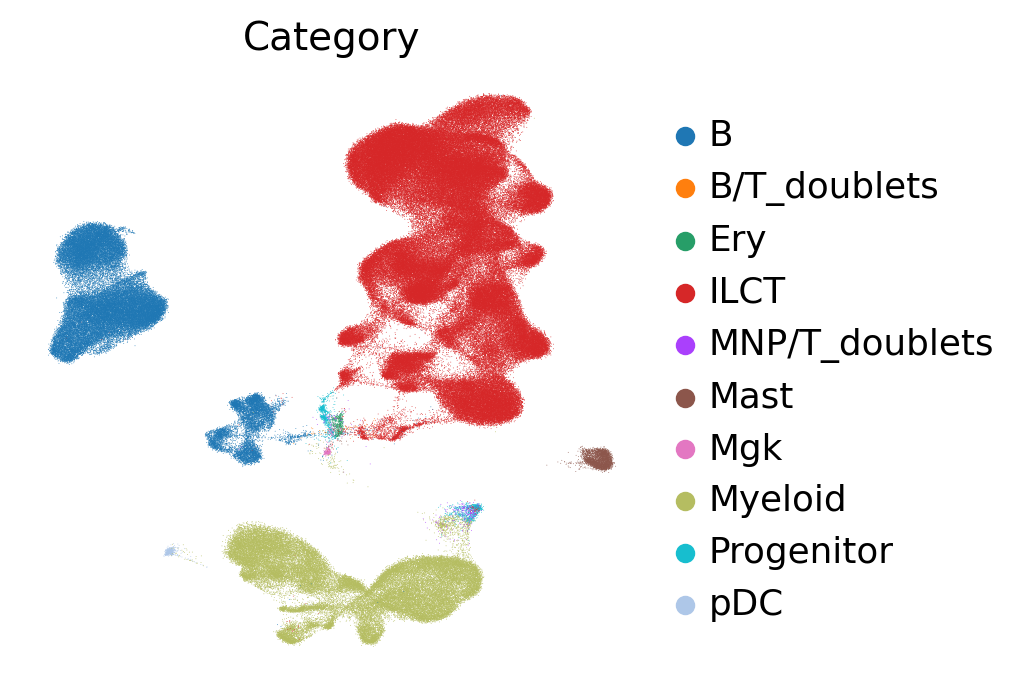

In [4]:
sc.pl.umap(adata, color='Category', frameon=False)

#### Subsetting the B cell compartment

In [4]:
imgt_vdj = pd.read_csv('/mnt/Science_revision/imgt_pip_vdj.csv')

In [5]:
imgt_vdj = list(imgt_vdj['0'])

In [6]:
adata.X.min()

-2.3022542983229757

In [7]:
adata.raw.X.min()

0.0

In [8]:
adata = adata.raw.to_adata()

In [9]:
adata.X.min()

0.0

In [10]:
list(adata.obs['Category'].unique())

['ILCT',
 'Myeloid',
 'B',
 'Mast',
 'pDC',
 'Progenitor',
 'Ery',
 'Mgk',
 'MNP/T_doublets',
 'B/T_doublets']

In [12]:
adata=adata[adata.obs['Category'].isin(['B']),:]

In [13]:
adata.raw = adata
sc.pp.highly_variable_genes(adata, subset=True)
hvg = list(adata.var[adata.var['highly_variable']==True].index)
nohvg = intersection(hvg,imgt_vdj )
adata.var.loc[nohvg,  'highly_variable'] = False
sc.pp.scale(adata, max_value=10)

extracting highly variable genes
    finished (0:00:03)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


In [14]:
bbknn.ridge_regression(adata, batch_key=['chem'], confounder_key=['new_predicted_labels'])

computing ridge regression
	finished: `.X` now features regression residuals
	`.layers['X_explained']` stores the expression explained by the technical effect (0:00:01)


In [15]:
sc.pp.pca(adata)
bbknn.bbknn(adata, batch_key='donor_id')
sc.tl.umap(adata)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:12)
computing batch balanced neighbors
	finished: added to `.uns['neighbors']`
	`.obsp['distances']`, distances for each pair of neighbors
	`.obsp['connectivities']`, weighted adjacency matrix (0:00:21)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:01:36)


In [17]:
sc.tl.leiden(adata)

running Leiden clustering
    finished: found 17 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:48)


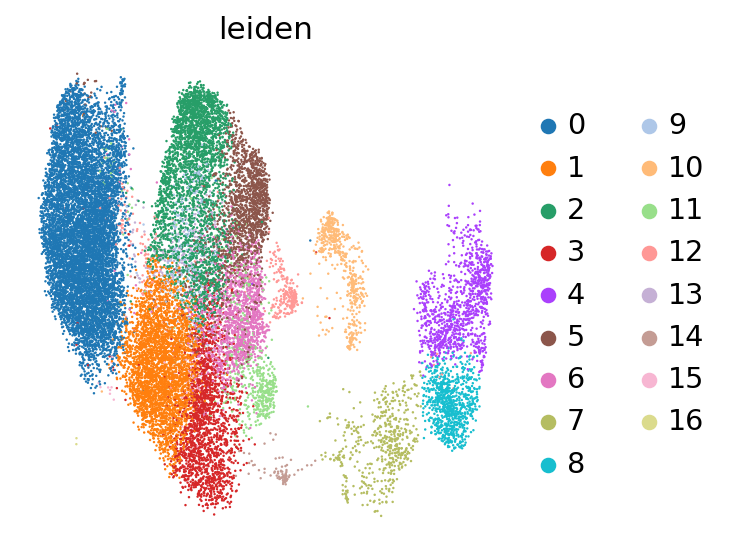

In [152]:
sc.pl.umap(adata, color=['leiden'], frameon=False)

In [19]:
adata.write('/mnt/Science_revision/write/TICA_B.h5ad')

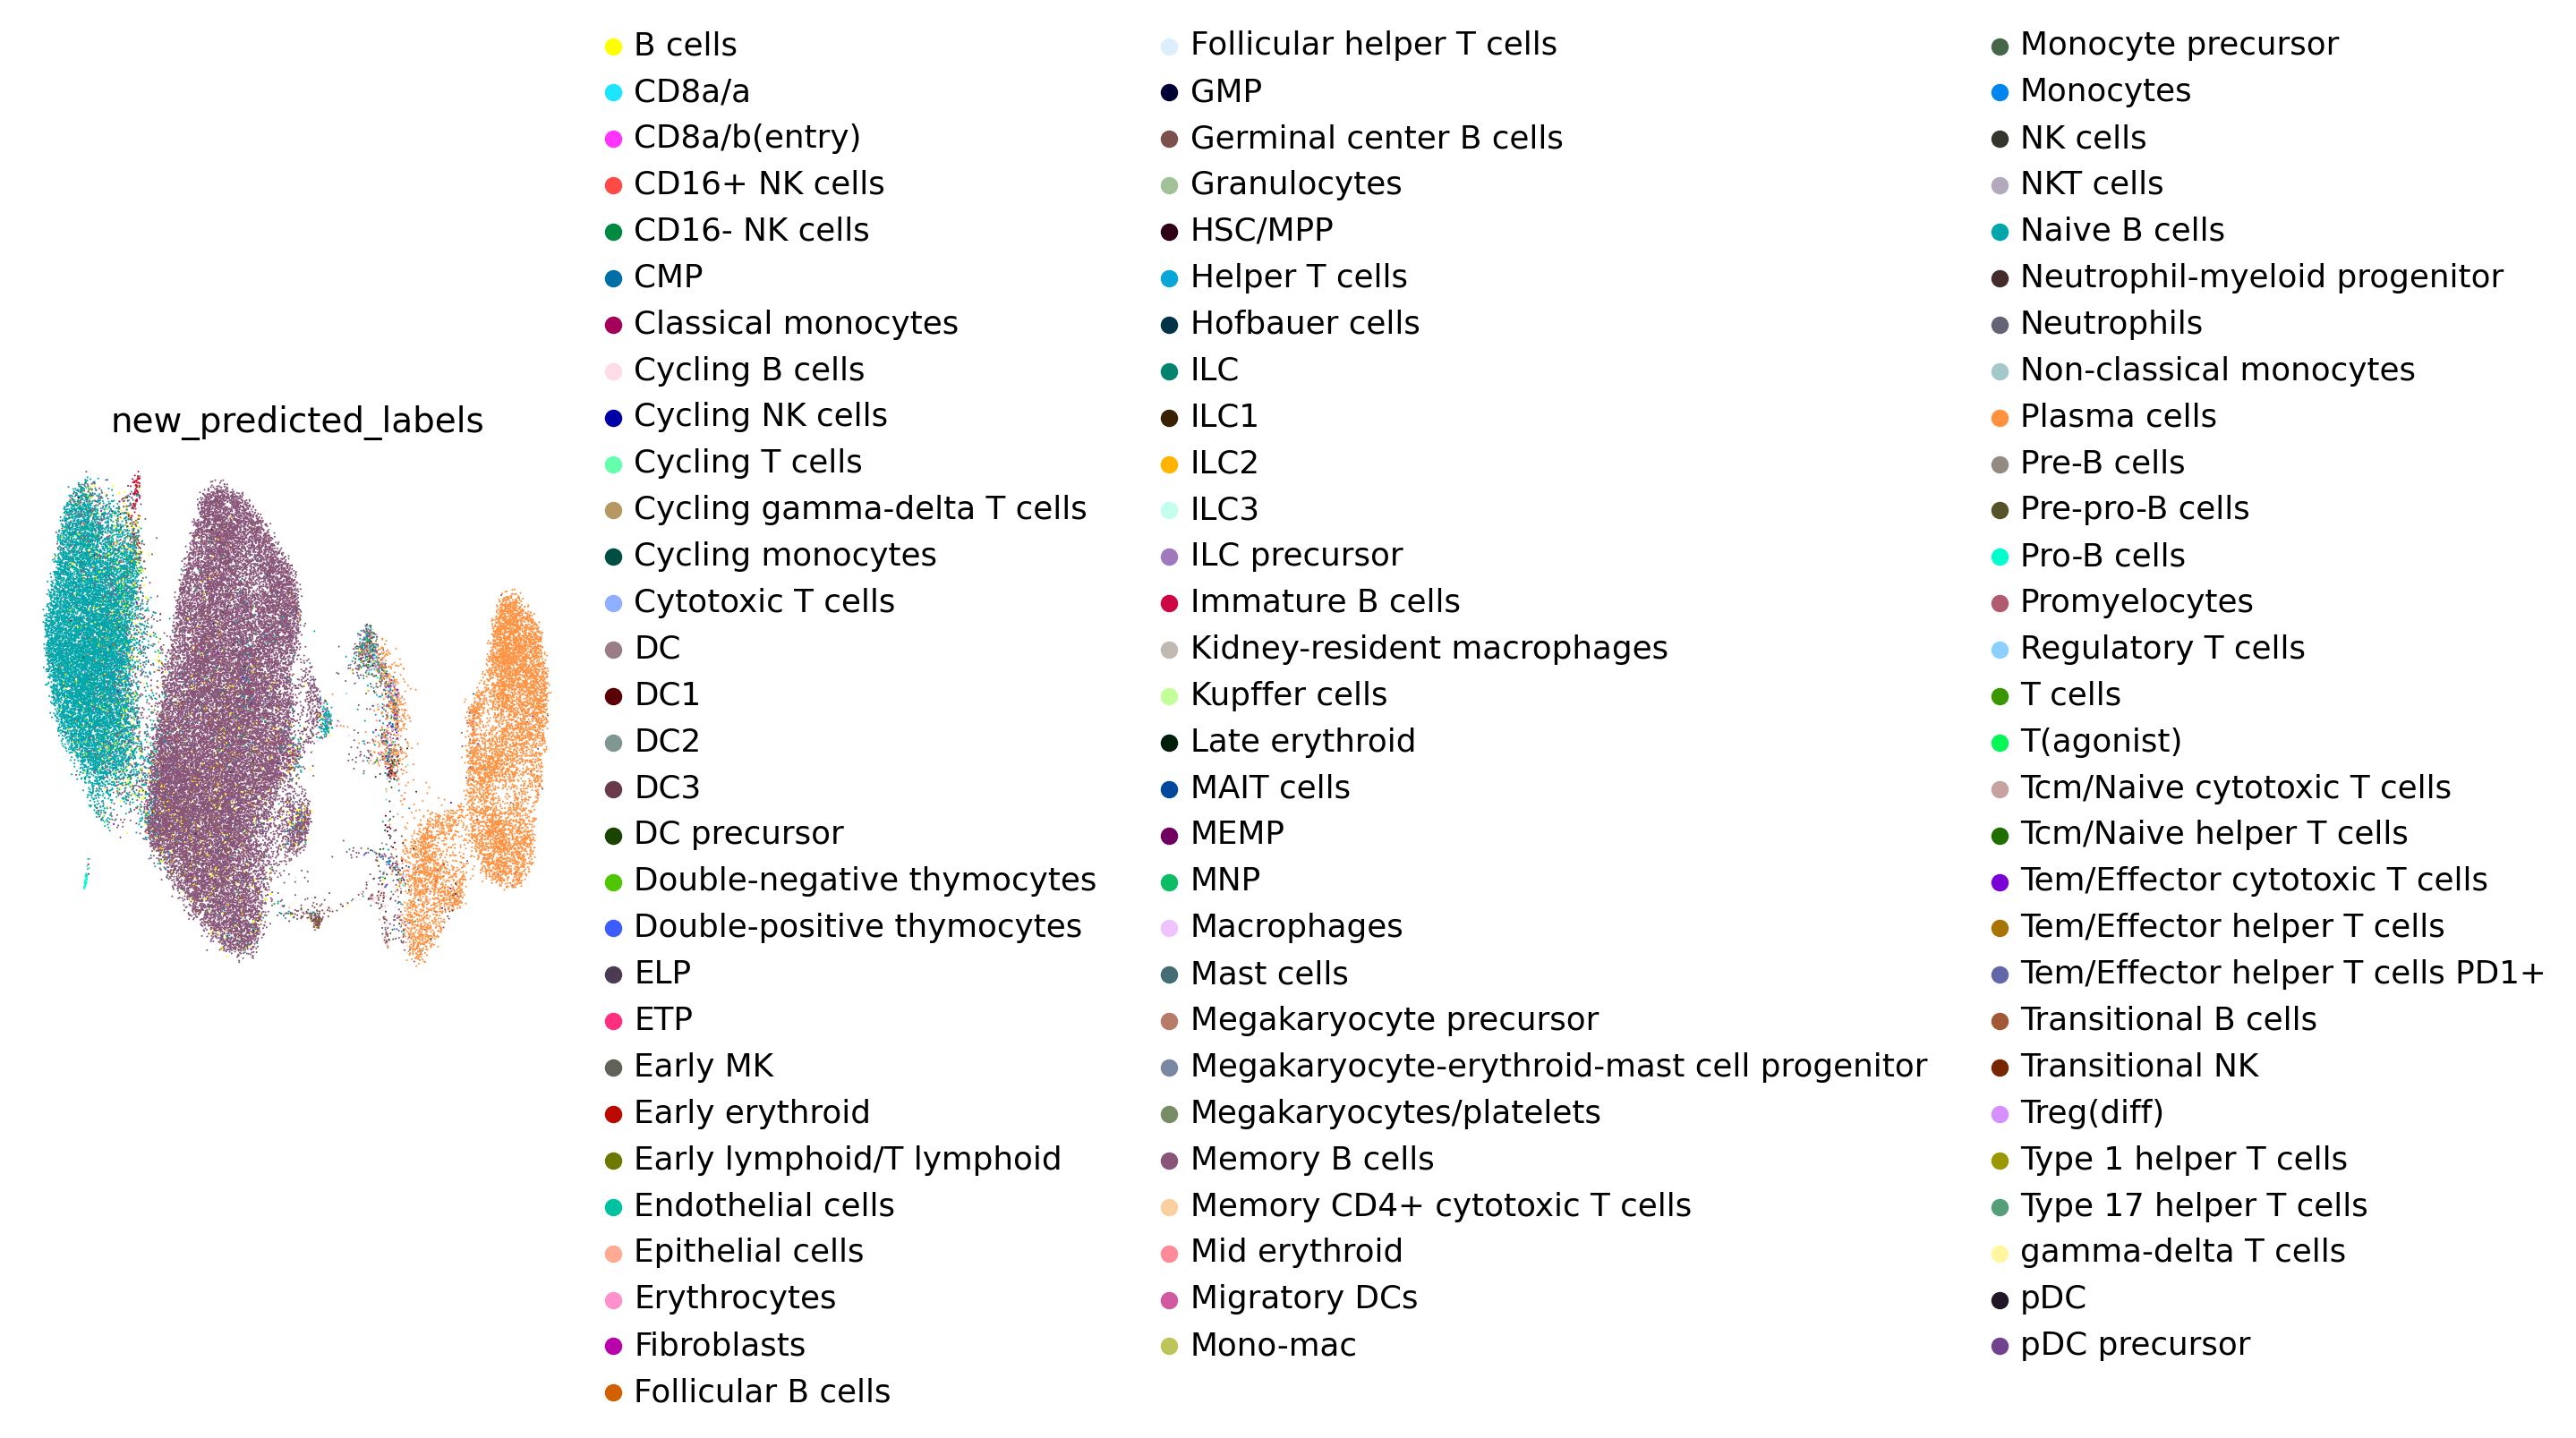

In [32]:
sc.pl.umap(adata, color=['new_predicted_labels'], frameon=False)

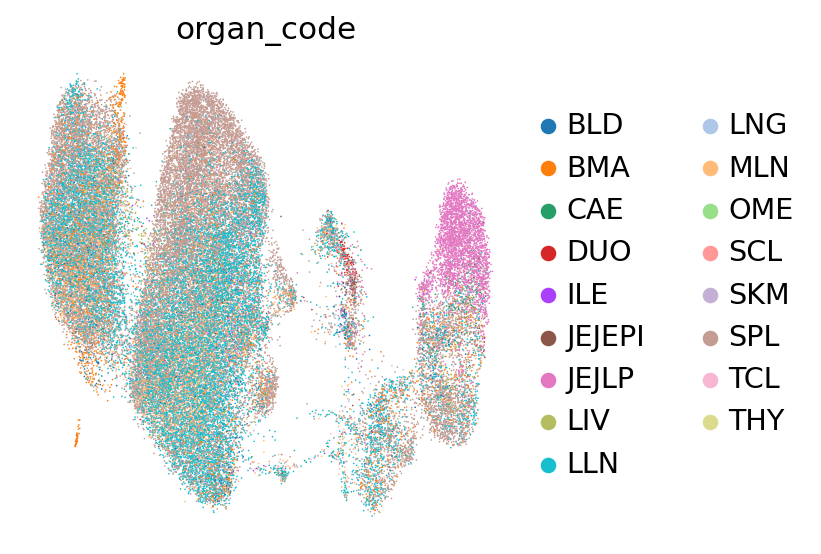

In [33]:
sc.set_figure_params(dpi_save=600)
sc.pl.umap(adata, color=['organ_code'], frameon=False, save='3C.pdf')

In [34]:
sc.tl.leiden(adata,resolution=20, key_added='leiden_20')

running Leiden clustering
    finished: found 381 clusters and added
    'leiden_20', the cluster labels (adata.obs, categorical) (0:02:02)


In [35]:
votes = pd.crosstab(adata.obs['new_predicted_labels'], adata.obs['leiden'])
majority = votes.idxmax()
adata.obs['new_predicted_labels_maj'] = majority[adata.obs['leiden'].values].values

In [36]:
votes = pd.crosstab(adata.obs['new_predicted_labels'], adata.obs['leiden_20'])
majority = votes.idxmax()
adata.obs['new_predicted_labels_maj20'] = majority[adata.obs['leiden_20'].values].values

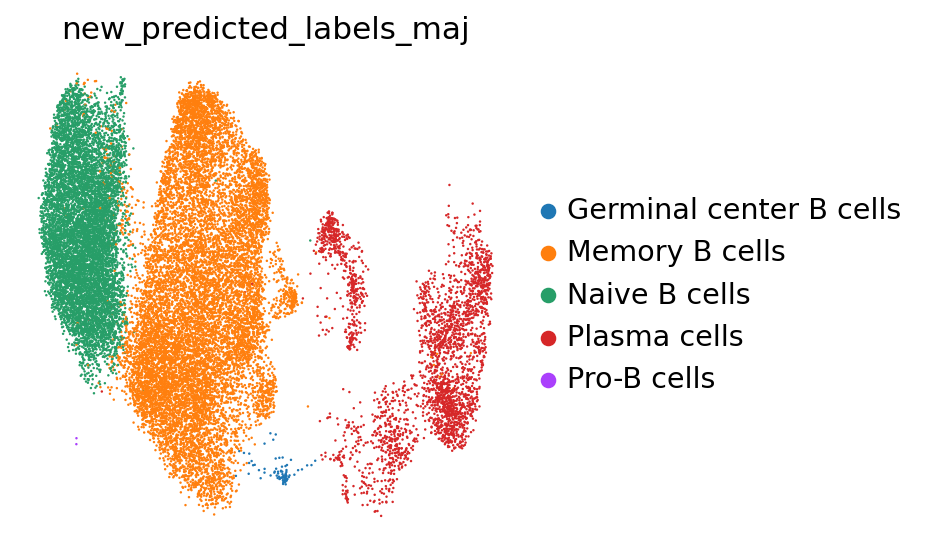

In [153]:
sc.pl.umap(adata, color='new_predicted_labels_maj', frameon=False)

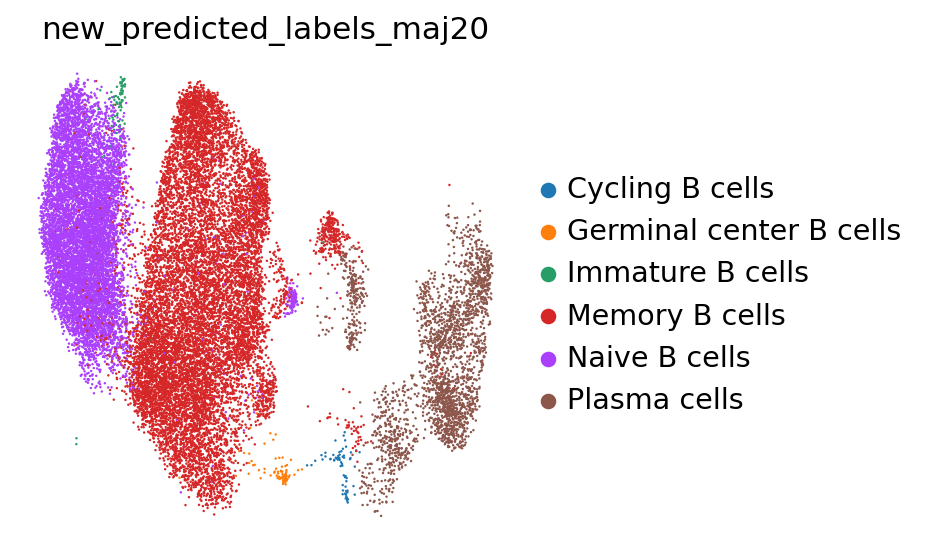

In [154]:
sc.pl.umap(adata, color='new_predicted_labels_maj20', frameon=False)

In [155]:
adata.obs['predicted_PIP_labels'] = pd.read_csv("/mnt/Science_revision/prediction_from_CellTypist_PIP.csv", index_col=0).loc[adata.obs_names, 'PIP'].values

... storing 'predicted_PIP_labels' as categorical


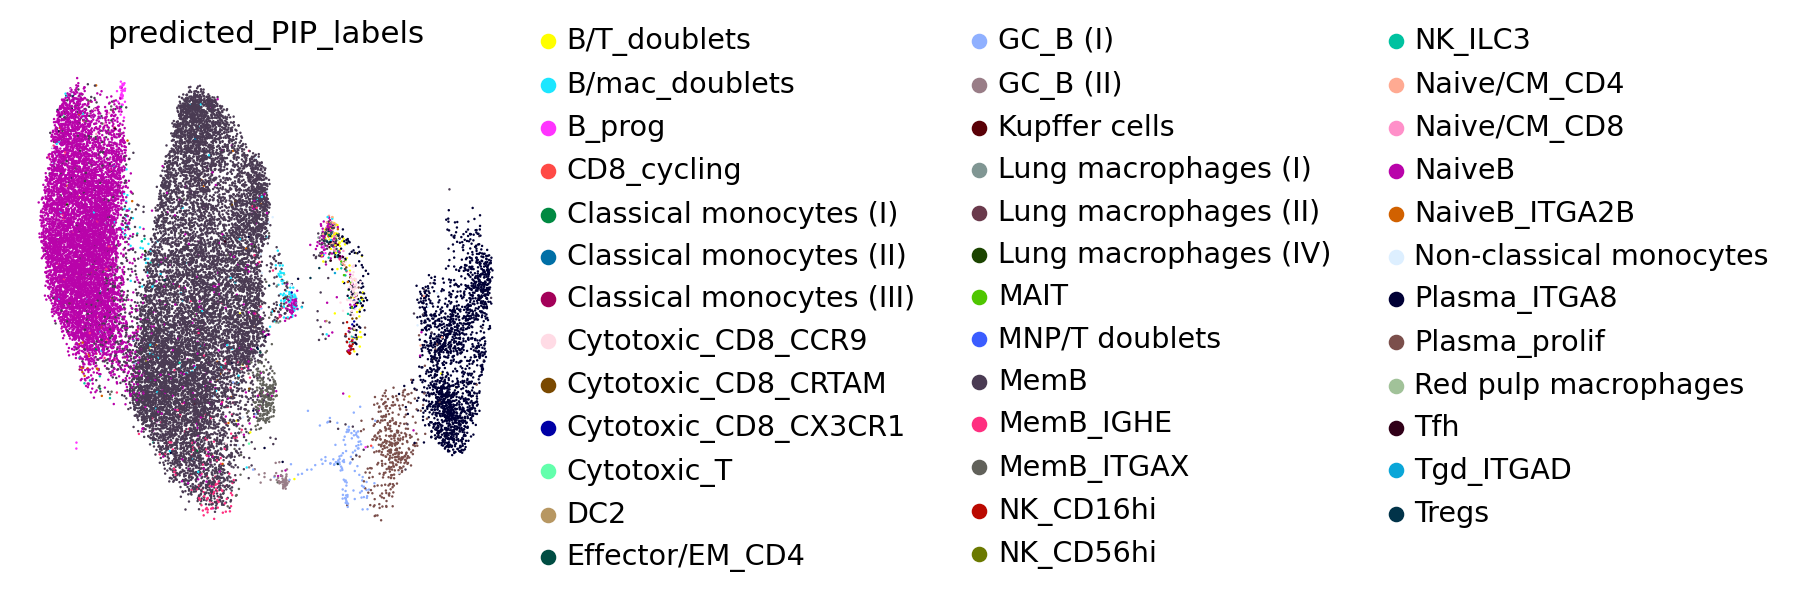

In [156]:
sc.pl.umap(adata, color=['predicted_PIP_labels'], frameon=False)

# Marker genes

In [67]:
sc.tl.rank_genes_groups(adata, groupby='leiden',method='wilcoxon',pts=True)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:03:07)


In [68]:
pts = adata.uns['rank_genes_groups']['pts']
pts_rest = adata.uns['rank_genes_groups']['pts_rest']

result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names

res = pd.DataFrame(index=range(0, pts.shape[0]))
for group in groups:
    df = pd.DataFrame({group + '_' + key: result[key][group] for key in ['names', 'pvals', 'pvals_adj', 'logfoldchanges']})
    df[group+'_pts'] = pts.loc[df[group + '_names'], group].values
    df[group+'_pts_rest'] = pts_rest.loc[df[group + '_names'], group].values
    res = res.join(df)


In [69]:
output = pd.DataFrame()
for group in groups:
       sub_res = res[[f"{group}_{key}" for key in ['names', 'pvals', 'pvals_adj', 'logfoldchanges', 'pts','pts_rest']]]
       sub_res.columns = ['names', 'pvals', 'pvals_adj', 'logfoldchanges', 'pts','pts_rest']
       sub_res['celltype'] = group
       flag = (sub_res['pvals'] < 0.05) & (sub_res['pts'] > 0.5) & (sub_res['pts_rest'] < 0.3)
       sub_res = sub_res[flag]
       output = output.append(sub_res)
output.to_csv('B_markers.csv', header=True, index=False)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-

In [70]:
output = pd.DataFrame()
for group in groups:
       sub_res = res[[f"{group}_{key}" for key in ['names', 'pvals', 'pvals_adj', 'logfoldchanges', 'pts','pts_rest']]]
       sub_res.columns = ['names', 'pvals', 'pvals_adj', 'logfoldchanges', 'pts','pts_rest']
       sub_res['celltype'] = group
       flag = (sub_res['pvals'] < 0.05) & (sub_res['pts'] > 0.15) & (sub_res['pts_rest'] < 0.08)
       sub_res = sub_res[flag]
       output = output.append(sub_res)
output.to_csv('B_low_exp_markers.csv', header=True, index=False)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-

In [71]:
output.head(10)

names          pvals      pvals_adj  logfoldchanges       pts  \
0         TCL1A   0.000000e+00   0.000000e+00        5.661910  0.782680   
12         IL4R   0.000000e+00   0.000000e+00        4.264935  0.503380   
50      COL19A1   0.000000e+00   0.000000e+00        3.087500  0.344126   
82       ZBTB16  1.219565e-310  2.975820e-308        2.983515  0.258094   
90        SKAP1  3.781839e-300  8.440188e-298        3.285068  0.259660   
103       CD200  2.210958e-264  4.006103e-262        3.724703  0.221234   
106       PCDH9  9.365593e-260  1.632334e-257        3.634498  0.219740   
127  AL139020.1  2.843011e-217  3.703097e-215        5.422773  0.183235   
152        TCL6  7.325877e-178  7.266515e-176        4.987347  0.168647   
211      ADARB1  3.652122e-107  1.823619e-105        2.839499  0.157831   

     pts_rest celltype  
0    0.045669        0  
12   0.061129        0  
50   0.071941        0  
82   0.052225        0  
90   0.061911        0  
103  0.028913        0  
106  0.028473        0  
127  0.005969        0  
152  0.008928        0  
211  0.037572        0

## Splitting naive from progenitor cells

#### subsetted and subclustered leiden clusters 0, 7 and 16 and run leiden with resolution 3

In [58]:
adata.obs['subdivide_0_7_16'] = pd.read_csv("/mnt/Science_revision/curated_B_1121.csv", index_col=0).leiden.values

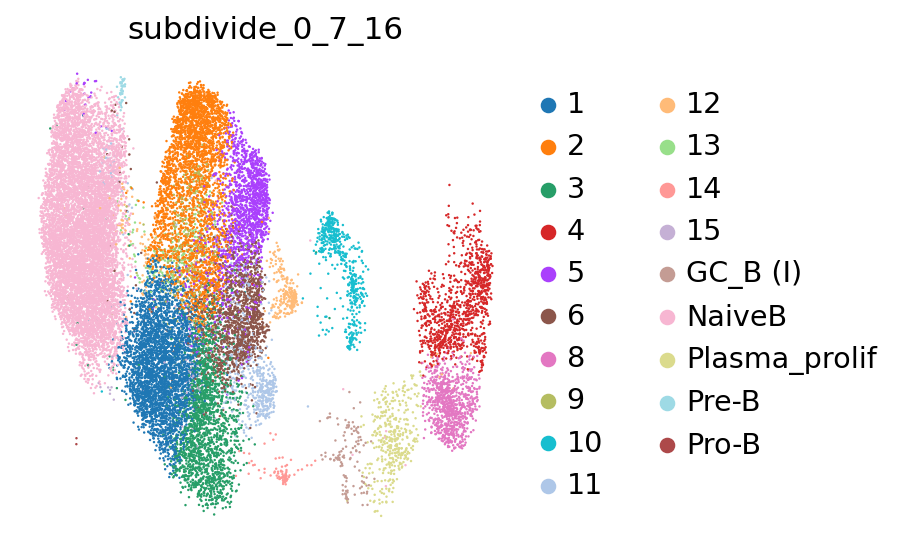

In [157]:
sc.pl.umap(adata, color='subdivide_0_7_16', frameon=False)

In [60]:
list(adata.obs['subdivide_0_7_16'].unique())

['2',
 'NaiveB',
 '4',
 '12',
 '3',
 '5',
 '8',
 '6',
 '9',
 '11',
 '10',
 '1',
 'GC_B (I)',
 '14',
 '15',
 '13',
 'Plasma_prolif',
 'Pro-B',
 'Pre-B']

In [61]:
b_annot = {'NaiveB':'Naive B cells',
           '12':'MNP/B doublets', 'GC_B (I)': 'GC_B (I)','Plasma_prolif':'Plasmablasts', 'Pro-B':'Pro-B',
 'Pre-B':'Pre-B',
 '2':'Memory B cells',
 '0':'Naive B cells',
 '5':'Memory B cells',
 '14':'GC_B (II)',
 '8':'Plasma cells',
 '4':'Plasma cells',
 '6':'Memory B cells',
 '9':'Memory B cells',
 '3':'Memory B cells',
 '10':'T/B doublets',
 '13':'Memory B cells',
 '1':'Memory B cells',
 '7':'Plasmablasts',
 '11':'Age-associated memory B cells',
  '15':'Memory B cells',
 '16':'B_progenitors'}

In [62]:
adata.obs['manual_annot_v2'] = adata.obs['subdivide_0_7_16'].map(b_annot)

In [63]:
list(adata.obs['manual_annot_v2'].unique())

['Memory B cells',
 'Naive B cells',
 'Plasma cells',
 'MNP/B doublets',
 'Age-associated memory B cells',
 'T/B doublets',
 'GC_B (I)',
 'GC_B (II)',
 'Plasmablasts',
 'Pro-B',
 'Pre-B']

In [64]:
ct_order = ['Pro-B',
 'Pre-B',
 'Naive B cells','Memory B cells','Age-associated memory B cells','GC_B (I)','GC_B (II)',
 'Plasma cells',
 'Plasmablasts',
 'MNP/B doublets',
  'T/B doublets']

... storing 'manual_annot_v2' as categorical


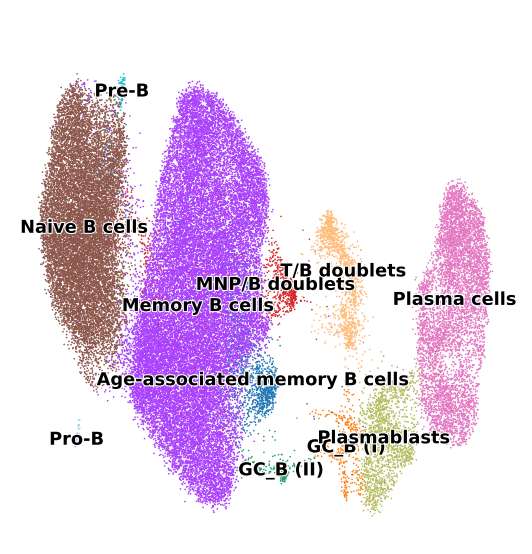

In [65]:
sc.pl.umap(adata, color='manual_annot_v2', frameon=False, groups=ct_order, title=' ', legend_loc='on data', legend_fontoutline=1, legend_fontsize=8, save='3A.pdf')

#### Marker genes for final annotation

In [155]:
sc.tl.rank_genes_groups(adata, groupby='manual_annot_v2',method='wilcoxon',pts=True)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:02:53)


In [156]:
pts = adata.uns['rank_genes_groups']['pts']
pts_rest = adata.uns['rank_genes_groups']['pts_rest']

result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names

res = pd.DataFrame(index=range(0, pts.shape[0]))
for group in groups:
    df = pd.DataFrame({group + '_' + key: result[key][group] for key in ['names', 'pvals', 'pvals_adj', 'logfoldchanges']})
    df[group+'_pts'] = pts.loc[df[group + '_names'], group].values
    df[group+'_pts_rest'] = pts_rest.loc[df[group + '_names'], group].values
    res = res.join(df)


In [157]:
output = pd.DataFrame()
for group in groups:
       sub_res = res[[f"{group}_{key}" for key in ['names', 'pvals', 'pvals_adj', 'logfoldchanges', 'pts','pts_rest']]]
       sub_res.columns = ['names', 'pvals', 'pvals_adj', 'logfoldchanges', 'pts','pts_rest']
       sub_res['celltype'] = group
       flag = (sub_res['pvals'] < 0.05) & (sub_res['pts'] > 0.5) & (sub_res['pts_rest'] < 0.3)
       sub_res = sub_res[flag]
       output = output.append(sub_res)
output.to_csv('B_anno_markers.csv', header=True, index=False)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-

In [158]:
output = pd.DataFrame()
for group in groups:
       sub_res = res[[f"{group}_{key}" for key in ['names', 'pvals', 'pvals_adj', 'logfoldchanges', 'pts','pts_rest']]]
       sub_res.columns = ['names', 'pvals', 'pvals_adj', 'logfoldchanges', 'pts','pts_rest']
       sub_res['celltype'] = group
       flag = (sub_res['pvals'] < 0.05) & (sub_res['pts'] > 0.15) & (sub_res['pts_rest'] < 0.08)
       sub_res = sub_res[flag]
       output = output.append(sub_res)
output.to_csv('B_anno_low_exp_markers.csv', header=True, index=False)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-

In [159]:
output.head(10)

names          pvals      pvals_adj  logfoldchanges       pts  \
11       FGR  1.485479e-123  4.530834e-120        3.701720  0.447477   
41       HCK   4.843704e-74   3.939654e-71        3.576930  0.340778   
62      EBI3   7.046568e-61   3.907749e-58        4.190988  0.297767   
68     ITGAX   1.063280e-56   5.405154e-54        5.126506  0.277916   
110   ZBTB32   1.106971e-39   3.523151e-37        2.740477  0.276261   
116     TFEC   6.843934e-38   2.070205e-35        2.284778  0.285360   
147     SOX5   3.400182e-33   7.876587e-31        4.922613  0.212572   
240    BCAR3   1.473826e-27   2.123761e-25        2.728487  0.224152   
252  SIGLEC6   7.890129e-27   1.081598e-24        3.565107  0.198511   
286    MS4A7   1.304588e-24   1.575883e-22        1.811998  0.245658   

     pts_rest                       celltype  
11   0.057776  Age-associated memory B cells  
41   0.035570  Age-associated memory B cells  
62   0.022448  Age-associated memory B cells  
68   0.012657  Age-associated memory B cells  
110  0.058967  Age-associated memory B cells  
116  0.070582  Age-associated memory B cells  
147  0.012303  Age-associated memory B cells  
240  0.043369  Age-associated memory B cells  
252  0.018222  Age-associated memory B cells  
286  0.072220  Age-associated memory B cells

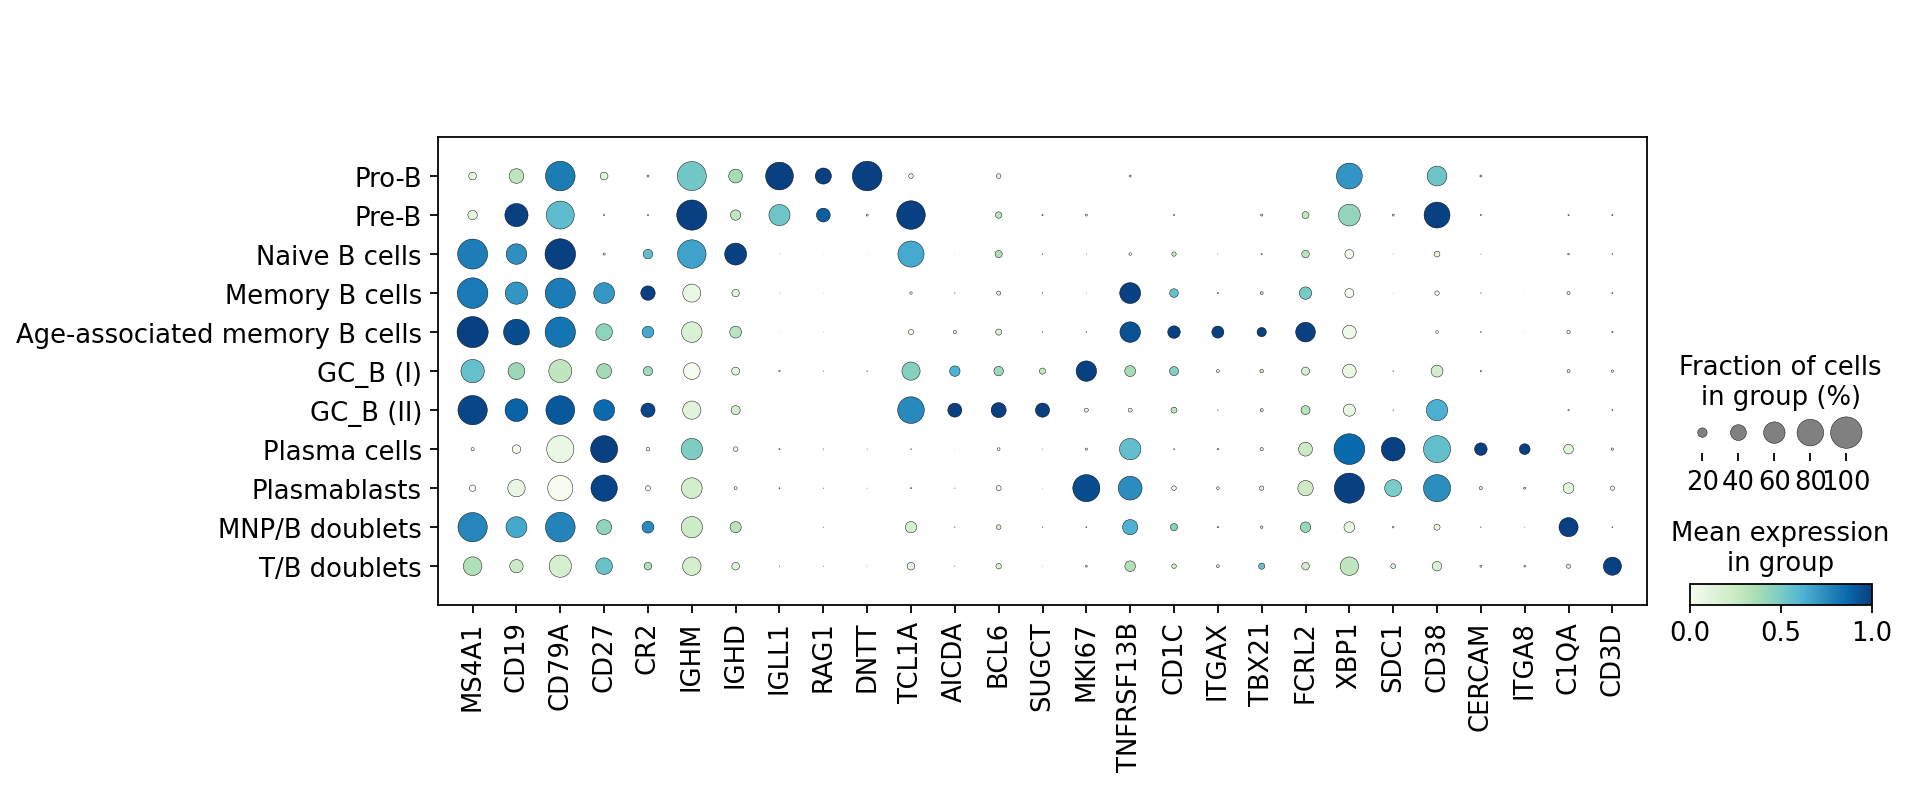

In [21]:
sc.set_figure_params(dpi_save=600)
sc.pl.dotplot(adata, var_names=['MS4A1','CD19','CD79A','CD27','CR2','IGHM','IGHD','IGLL1','RAG1','DNTT','TCL1A','AICDA','BCL6','SUGCT','MKI67','TNFRSF13B','CD1C','ITGAX','TBX21','FCRL2','XBP1','SDC1','CD38','CERCAM','ITGA8','C1QA','CD3D'], groupby='manual_annot_v2', standard_scale='var', cmap='GnBu', categories_order=ct_order, save='3B.pdf')

# BCR data

### adding BCR data from Hamish's pipeline

In [128]:
## adding BCR information to the B cell object
Ig = pd.read_csv("/mnt/Science_revision/20211028_BCR_Metadata_HK_annotated.txt", delimiter='\t')
Ig.index = Ig['GEX_barcode']
for col in Ig.columns:
    adata.obs[col] = Ig[col]

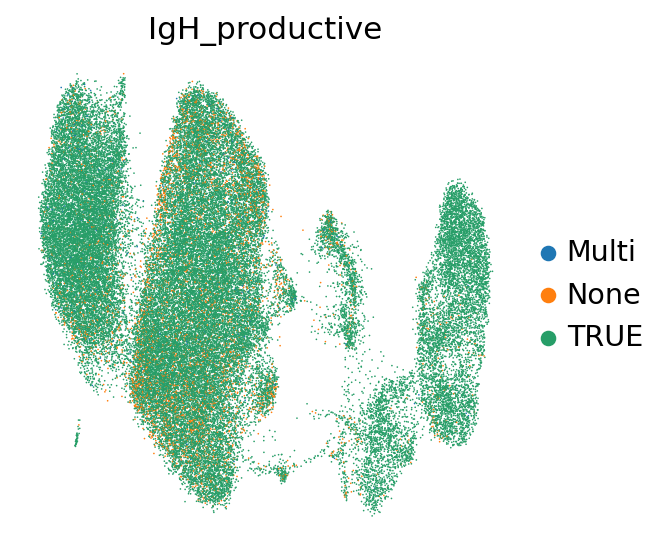

In [130]:
sc.pl.umap(adata, color='IgH_productive', frameon=False)

In [131]:
adata.obs['IgH_productive'].value_counts()

TRUE     24637
None      5023
Multi      284
Name: IgH_productive, dtype: int64

In [132]:
adata.write('/mnt/Science_revision/write/TICA_B_BCR.h5ad')

In [133]:
adata = adata[adata.obs['IgH_productive'] == 'TRUE']

In [134]:
adata.write('/mnt/Science_revision/write/TICA_B_BCR.h5ad')

Trying to set attribute `._uns` of view, copying.


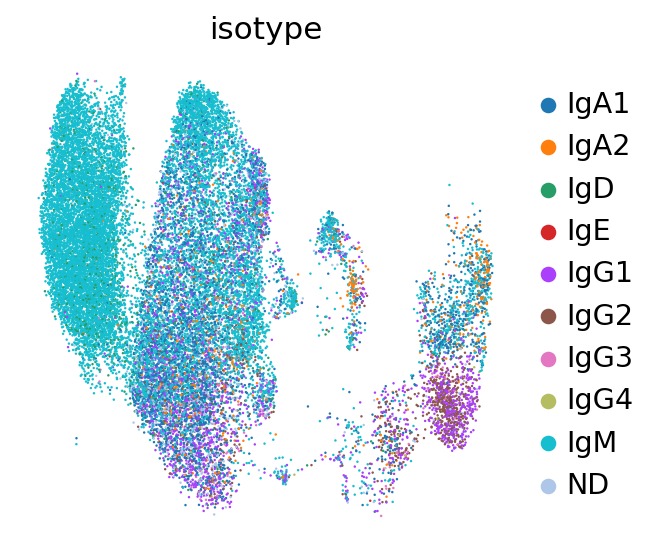

In [137]:
sc.pl.umap(adata, color='isotype', frameon=False)

In [138]:
## add clone size

In [139]:
adata.obs['pandonor_clone_id'].value_counts()

18278    149
26368     96
29260     56
48200     49
42976     35
        ... 
32648      1
32652      1
32653      1
32655      1
1          1
Name: pandonor_clone_id, Length: 22915, dtype: int64

In [141]:
clone_size_dict = adata.obs['pandonor_clone_id'].value_counts().to_dict()

In [143]:
adata.obs['clone_size'] = adata.obs['pandonor_clone_id'].map(clone_size_dict)

In [144]:
adata.obs['IgH_productive'].unique()

['TRUE']
Categories (1, object): ['TRUE']

In [145]:
adata.write('/mnt/Science_revision/write/TICA_B_BCR.h5ad')

In [77]:
adata.obs.to_csv('/mnt/Science_revision/PIPCZI_meta_B.csv')

In [146]:
clonal = adata[adata.obs['clone_size']>10]

In [147]:
clonal.obs['clone_size'].value_counts()

149    149
96      96
56      56
25      50
49      49
16      48
11      44
35      35
32      32
27      27
17      17
15      15
14      14
13      13
12      12
Name: clone_size, dtype: int64

In [114]:
clonal.obs['pandonor_clone_id'].value_counts()

18278    149
26368     96
29260     56
48200     49
42976     35
43363     32
38597     27
4969      25
40971     25
29487     17
38543     16
29489     16
14724     16
1869      15
41094     14
41399     13
24056     12
24229     11
10035     11
9922      11
26370     11
Name: pandonor_clone_id, dtype: int64

In [148]:
clonal[~clonal.obs['pandonor_clone_id'].isin(['None','Multi'])]

View of AnnData object with n_obs × n_vars = 657 × 1196
    obs: 'sample', 'Source ID', 'sex', 'patient no', 'organ code', 'sample ID', 'fraction_mito', 'n_genes', 'n_counts', 'log_counts', 'batch', 'organ_code', 'donor_id', 'combined_ID', 'HTO_C0251', 'HTO_C0252', 'HTO_C0253', 'HTO_C0254', 'HTO_C0255', 'HTO_C0256', 'HTO_C0257', 'total_hto_counts', 'fraction_HTO_C0251', 'fraction_HTO_C0252', 'most_likely_hypothesis', 'cluster_feature', 'negative_hypothesis_probability', 'singlet_hypothesis_probability', 'doublet_hypothesis_probability', 'Classification', 'fraction_HTO_C0253', 'fraction_HTO_C0254', 'fraction_HTO_C0255', 'fraction_HTO_C0256', 'fraction_HTO_C0257', 'hash+lib', 'sample_ID', 'leiden', 'Stimulation', 'C251', 'C252', 'C253', 'C254', 'C255', 'C256', 'C257', 'C258', 'fraction_HTOC251', 'fraction_HTOC252', 'fraction_HTOC253', 'fraction_HTOC254', 'fraction_HTOC255', 'fraction_HTOC256', 'fraction_HTOC257', 'fraction_HTOC258', 'chem', 'index', 'scrublet_leiden', 'scrublet_score', '

In [149]:
clonal = clonal[~clonal.obs['pandonor_clone_id'].isin(['None','Multi'])]

In [150]:
clonal.obs.to_csv('/mnt/Science_revision/TICA_B_BCR_clonotypes.csv')